In [77]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import cv2
from tensorflow.keras.preprocessing.image import array_to_img, ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten,Dropout,Conv2D

# CSV files

DIR_PATH = "/kaggle/input/facial-keypoints-detection/"
training_data = pd.read_csv(f"{DIR_PATH}training.zip")
test_data = pd.read_csv(f"{DIR_PATH}test.zip")
id_lookup_table = pd.read_csv(f"{DIR_PATH}IdLookupTable.csv")

In [90]:
# Data 

def image_to_array(image):
    image = np.array([int(elem) for elem in image.split(" ")])
    image = image.reshape(96,96,1) 
    return image

def get_training_data(training_data=training_data):
    data = training_data.fillna(method = "ffill")
    images = [image_to_array(image) for image in np.array(data["Image"])] 
    key_points = data.drop(["Image"], axis = 1).to_numpy()

    x_train, x_test, y_train, y_test = train_test_split(np.array(images, dtype = float), key_points)

    return x_train, x_test, y_train, y_test

def get_testing_data(test_data=test_data):
    images = [image_to_array(image) for image in np.array(test_data["Image"])] 
    return np.array(images, dtype = float)

def create_submission(predictions, id_lookup_table=id_lookup_table):
    features_n = list(id_lookup_table['FeatureName'])
    img_ids = list(id_lookup_table['ImageId']-1) 

    features_lst = [features_n.index(feature) for feature in features_n]

    submission = pd.DataFrame({
        "RowId": list(id_lookup_table['RowId']),
        "Location": [predictions[x][y] for x, y in zip(img_ids, features_lst)]
    })
    submission.to_csv("submission.csv",index = False)
    
# Utilities

def show_image(image, training_key_points, test_key_points= None):
    plt.imshow(image, cmap="gray")

    training_key_points = training_key_points.reshape([15, 2])
    plt.plot(training_key_points[:,0], training_key_points[:,1], 'gx')
    
    if test_key_points:
        test_key_points = test_key_points.reshape([15, 2])
        plt.plot(test_key_points[:,0], test_key_points[:,1], 'rx')


In [67]:
x_train, x_test, y_train, y_test = get_training_data()

In [6]:
test_image = get_testing_data()

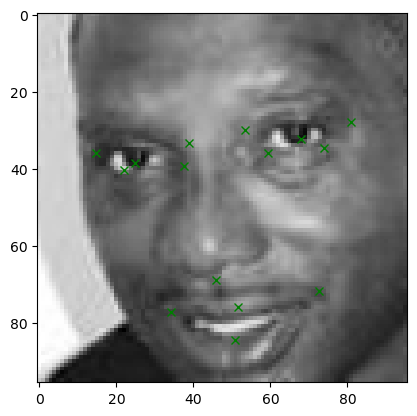

In [91]:
show_image(image=x_train[2], training_key_points=y_train[2])

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3,3),input_shape = (96, 96, 1),activation = "relu"),
    tf.keras.layers.MaxPooling2D((2,2) ),
    tf.keras.layers.Conv2D(128, (3,3),activation = "relu"),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(256, (3,3),activation = "relu"),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(512, (3,3),activation = "relu"),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation = "relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation = "relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(30, activation  = "relu")
    
])

model.compile(
    optimizer = "adam",
    loss = "mae",
    metrics = ["accuracy"]
)

model.fit(x_train.astype(float), y_train.astype(float), epochs = 35)


Epoch 1/35
104/166 [=================>............] - ETA: 1:04 - loss: 16.6291 - accuracy: 0.2539

In [21]:
predictions = model.predict(test_image)
create_submission(predictions)

56/56 [==============================] - 14s 244ms/step
